# Part 2: Simulation Data Analysis
### Dynamical Evolution of a Hernquist Elliptical Galaxy in an NFW Halo with a Massive Perturber

Loading and reading the simulation output without the perturber to check equilibrium.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm
from matplotlib import animation
from matplotlib.animation import PillowWriter, FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import re

In [2]:
file = open('./gal_nfw_pert_20_05_3_out.txt', 'r')

N = int(file.readline())
time = []
masses = []
x = []
y = []
z = []
vx = []
vy = []
vz = []

step = 3 + 3*N
i = 1
j = 0

while(True):   
    line = file.readline()
    
    if line=='':
        file.close()
        break
    
    i += 1
    
    k = i-j*step
    if (k==3): time.append(float(line))
    elif (j==0 and (k > 3 and k <= 3+N)): 
        masses.append(float(line))
    elif (k > 3+N and k <= 3+2*N): 
        line = [float(x) for x in line.split()]
        x.append(line[0])
        y.append(line[1])
        z.append(line[2])
    elif (k > 3+2*N and k <= 3+3*N):
        line = [float(x) for x in line.split()]
        vx.append(line[0])
        vy.append(line[1])
        vz.append(line[2])
        
    if i%step==0: j += 1
    

In [3]:
time = np.array(time)
masses = np.array(masses)
x = np.array(x).reshape(len(time), N).T
y = np.array(y).reshape(len(time), N).T
z = np.array(z).reshape(len(time), N).T
vx = np.array(vx).reshape(len(time), N).T
vy = np.array(vy).reshape(len(time), N).T
vz = np.array(vz).reshape(len(time), N).T

In [4]:
M = np.sum(masses)
print(f'M = {M:.4f}')

M = 1.1050


In [5]:
G = 1.0  # internal units
M_NFW = 1.0  # Total dark matter mass (virial mass)
r_s = 1.0 # Scale radius for NFW profile
c = 10.0  # Concentration parameter for the NFW profile = r_vir / r_s
M_hernquist = 0.1 ## Total stellar mass
a_hernquist = 0.2424  # Scale radius for Hernquist profile
N_stars = 3000  # Number of particles for the stellar component 
N_halo = 7000  # Number of particles for the dark matter halo

m_star = M_hernquist / N_stars  # Mass of each star particle
m_halo = M_NFW / N_halo  # Mass of each dark matter particle

In [6]:
M_pert = masses[-1]
print(f'M_pert = {M_pert:.4f}')

M_pert = 0.0050


## Check the stability of the system (without the perturber) in equilibrium

### Computation of Lagrangian radii

The **Lagrangian radii** represent the spherical radii enclosing fixed fractions of the system’s total mass (e.g., 10%, 50%, 70%, 90%). By tracking their evolution over time, we can assess whether the system undergoes significant structural changes or has settled into a stable configuration. In an ideal equilibrium state, the Lagrangian radii should remain approximately constant, indicating that mass shells are neither collapsing nor expanding over time. 

In [56]:
def center_of_mass(x, y, z, masses):
    x_com = np.sum(x * masses) / M
    y_com = np.sum(y * masses) / M
    z_com = np.sum(z * masses) / M
    return x_com, y_com, z_com

def lagrangian_radii(x, y, z, masses, mass_fractions=[0.1, 0.5, 0.7, 0.9]):
    x_com, y_com, z_com = center_of_mass(x, y, z, masses)
    r = np.sqrt((x - x_com) ** 2 + (y - y_com) ** 2 + (z - z_com) ** 2)
    
    # Sort by radius
    sorted_indices = np.argsort(r)
    r_sorted = r[sorted_indices]
    m_sorted = masses[sorted_indices]
    
    # Compute cumulative mass
    M_tot = np.sum(masses)
    M_cum = np.cumsum(m_sorted) / M_tot  # Fractional cumulative mass
    
    r_lagrangian = np.interp(mass_fractions, M_cum, r_sorted)
    return r_lagrangian

fractions = [0.1, 0.5, 0.7, 0.9]

# Compute Lagrangian radii for each time step
r_lagrangian_all = np.zeros((len(fractions), len(time)))

for t in range(len(time)):
    r_lagrangian_all[:, t] = lagrangian_radii(x[:, t], y[:, t], z[:, t], masses, mass_fractions=fractions)


#### Jeans method

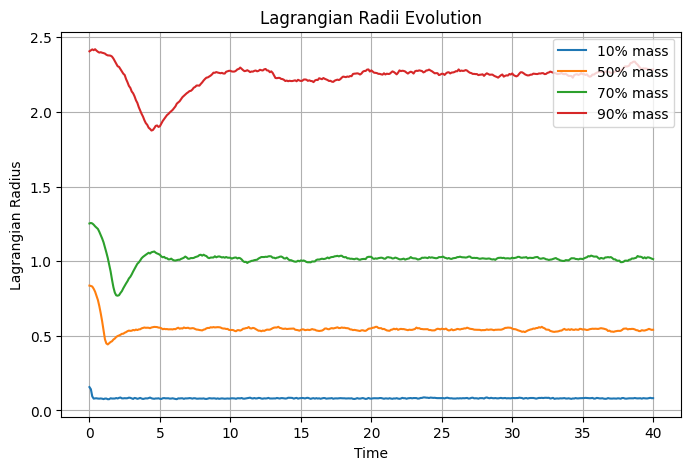

In [57]:
# Plot Lagrangian radii vs time
plt.figure(figsize=(8, 5))
for i, frac in enumerate(fractions):
    plt.plot(time, r_lagrangian_all[i], label=f'{int(frac * 100)}% mass')

plt.xlabel('Time')
plt.ylabel('Lagrangian Radius')
plt.title('Lagrangian Radii Evolution')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

#### Eddington method

<img src="lag_radii_edd6.png" align="center" width="700px"/>

In the plot above, the Lagrangian radii initially exhibit contraction, especially at large mass fractions (e.g., 70% and 90%), which indicates that the outer parts of the system were initially out of equilibrium and responded by collapsing inward, this is probably due to small deviations from equilibrium introduced by its construction and the discreteness of particles. This early evolution is a manifestation of **violent relaxation**, a transient phase where the system redistributes energy and mass to approach a more stable configuration. After this initial phase — around time  $t \sim 5$ — all mass shells stabilize, and the Lagrangian radii fluctuate around steady values. This behavior confirms that the system has settled into a quasi-equilibrium, and its phase-space distribution is no longer evolving significantly.

Given the same initial conditions, the equal number of particle and the same command line in the treecode setting, the **Jeans method performs better** in the definition of the equilibrium of the system (stars + dark matter halo). Therefore, from now on, we will only use the configuration initialized by this method.

### Assessing Dynamical Equilibrium via the Virial Ratio

To further verify whether an N-body system has reached dynamical equilibrium and eventually when it reaches it, we analyze the **virial ratio**, defined as:

$$
Q(t) = \frac{2T}{|U|}
$$

where:
- $T $ is the total kinetic energy,
- $U$ is the total potential energy of the system.

According to the virial theorem, a stable, self-gravitating system in equilibrium satisfies:

$$
2T + U = 0 \quad \Rightarrow \quad Q(t) = 1
$$

In this notebook, we extract the kinetic and potential energies at each simulation time step from the log file generated by the hierarchical Barnes-Hut treecode. The log provides values for $T$, $U$, and $-T/U$, from which we compute:

$$
\text{Virial Ratio} = 2 \cdot \left( \frac{T}{|U|} \right)
$$

This allows us to monitor the evolution of the system and determine when it settles into a virialized configuration.

Typically, a system is considered to have reached equilibrium when the virial ratio remains approximately constant and close to 1, usually within the range:

$$
0.95 \leq Q(t) \leq 1.05
$$

This method is widely used in the literature (e.g., Kazantzidis et al. 2004; Widrow & Dubinski 2005) to ensure the physical validity of numerical initial conditions before introducing perturbations or studying long-term evolution.


In [43]:
filename = "logout_jeans.txt"

# Read full file into a string
with open(filename, "r") as f:
    log_text = f.read()

In [ ]:
# extract values from the log file
pattern = re.compile(
    r"^\s*([\d]+\.\d+)\s+[\d\.]+\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)", re.MULTILINE
)
matches = pattern.findall(log_text)

# Create a DataFrame
logdata = pd.DataFrame(matches, columns=["time", "-T/U"]).astype(float)
logdata["time"] = logdata["time"].astype(float)
logdata["-T/U"] = logdata["-T/U"].astype(float)
logdata = logdata[logdata.index % 2 != 0]

# Compute virial ratio
logdata["virial_ratio"] = 2 * logdata["-T/U"]


In [53]:
logdata

,time,-T/U,virial_ratio
1,0.000,0.20838,0.41676
3,0.010,0.20854,0.41708
5,0.020,0.20949,0.41898
7,0.030,0.21129,0.42258
9,0.040,0.21396,0.42792
...,...,...,...
7995,39.969,0.47824,0.95648
7997,39.979,0.47779,0.95558
7999,39.989,0.47723,0.95446
8001,39.999,0.47652,0.95304


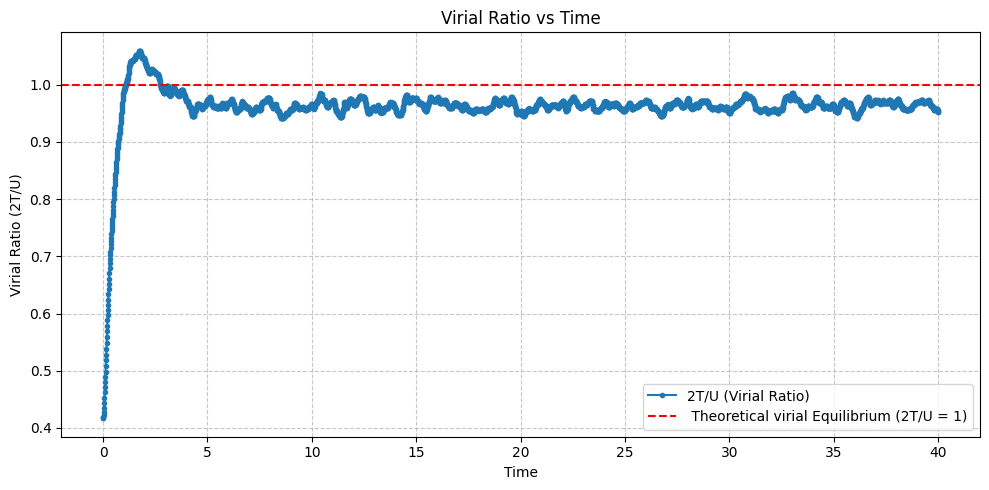

In [ ]:
# Plot of the virial ratio
plt.figure(figsize=(10, 5))
plt.plot(logdata["time"], logdata["virial_ratio"], marker='o', markersize=3, label="2T/U (Virial Ratio)")
plt.axhline(1.0, color="red", linestyle="--", label=" Theoretical virial Equilibrium (2T/U = 1)")
plt.xlabel("Time")
plt.ylabel("Virial Ratio (2T/U)")
plt.title("Virial Ratio vs Time")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Note: in order to choose the right time-threshold to search for virial equilibrium, a first period of time was skipped, considering visual inspection of the lagrangian radii plot above. After that, it is ensured that for a $N = 50$ number of steps the $Q$ value needs to be constant in a definite high range, to be considered "virial equilibrium".

In [ ]:
# Value of the virial ratio at which we consider the system to be in virial equilibrium
# Let's define a time threshold in order to skip initial instability

start_time_threshold = 10.0 

subset = logdata[logdata["time"] > start_time_threshold].copy()

#look for N consecutive points in the plateau range [0.95, 1.05]
N = 50 #averaging over 5 internal time units
lower, upper = 0.95, 1.05
in_plateau = subset["smoothed"].between(lower, upper)
plateau_run = in_plateau.rolling(window=N, min_periods=N).sum()

# Get the first index in the filtered subset where the condition is met
stable_index = plateau_run[plateau_run == N].first_valid_index()

if stable_index is not None:
    plateau_start_time_custom = subset.loc[stable_index, "time"]
    plateau_mean_value_custom = subset.loc[stable_index:stable_index + N, "smoothed"].mean() # What the average value of that plateau is
else:
    plateau_start_time_custom = None
    plateau_mean_value_custom = None

print("First time where the criteria for the plateau is satisfied: ", plateau_start_time_custom)
print("Average value of the plateau: ", plateau_mean_value_custom)


First time where the criteria for the plateau is satisfied:  10.5
Average value of the plateau:  0.9699424615384615


To estimate the virial equilibrium level of the system, we manually selected the time $t = 10.5$ as the starting point of the relaxation phase. This choice is based on the visual inspection of both the Lagrangian radii and the virial ratio evolution, which indicate that the system has overcome the initial transient instability.

We then computed the average value of the smoothed virial ratio over the subsequent 50 time steps, yielding:

$$
\langle 2T / |U| \rangle \approx 0.96
$$

This value confirms that the system has reached a dynamically relaxed configuration and justifies the use of this snapshot for further analysis.


**IMPORTANT**: Having verified that the system reaches dynamical equilibrium at $t = 10.5$, we extract a snapshot at this time and use it as the new initial condition for our perturber-insertion simulations. This allows us to isolate the dynamical impact of the perturber from the effects of the initial relaxation phase.

## Analysis with the perturber

In [7]:
x_pert = x[-1]
y_pert = y[-1]
z_pert = z[-1]
vx_pert = vx[-1]
vy_pert = vy[-1]
vz_pert = vz[-1]

r_pert = np.sqrt(x_pert**2 + y_pert**2 + z_pert**2)
v_pert = np.sqrt(vx_pert**2 + vy_pert**2 + vz_pert**2)

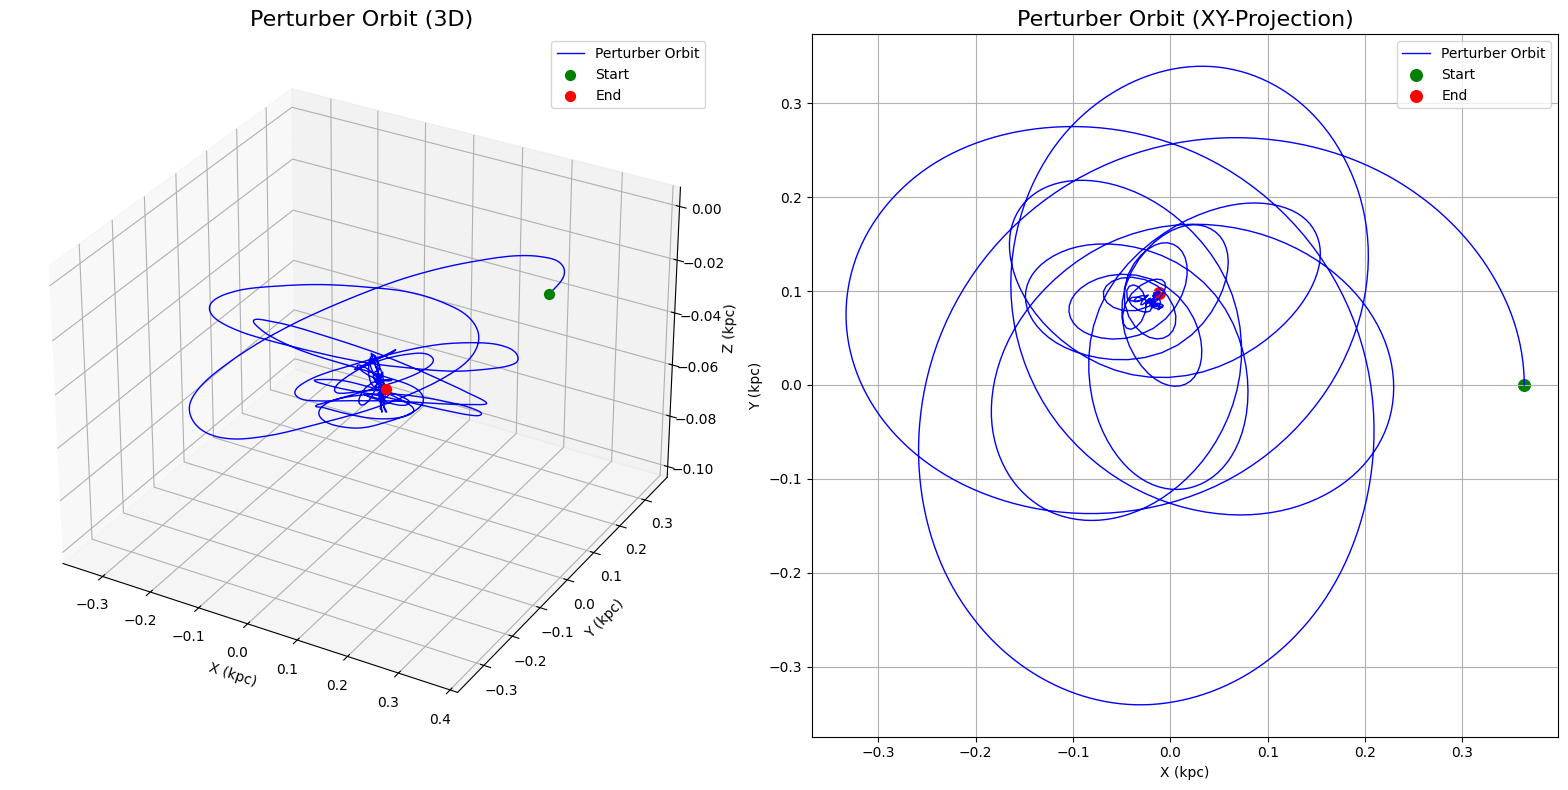

In [8]:
#perturber started at 90th quantile of the distribution
fig = plt.figure(figsize=(16, 8))

# 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_pert, y_pert, z_pert, color='blue', lw=1, label='Perturber Orbit')
ax1.scatter(x_pert[0], y_pert[0], z_pert[0], color='green', label='Start', s=50)
ax1.scatter(x_pert[-1], y_pert[-1], z_pert[-1], color='red', label='End', s=50)
ax1.set_title("Perturber Orbit (3D)", fontsize=16)
ax1.set_xlabel("X (kpc)")
ax1.set_ylabel("Y (kpc)")
ax1.set_zlabel("Z (kpc)")
ax1.legend()

# 2D Plot 
ax2 = fig.add_subplot(122)
ax2.plot(x_pert, y_pert, color='blue', lw=1, label='Perturber Orbit')
ax2.scatter(x_pert[0], y_pert[0], color='green', label='Start', s=70)
ax2.scatter(x_pert[-1], y_pert[-1], color='red', label='End', s=70)
ax2.set_title("Perturber Orbit (XY-Projection)", fontsize=16)
ax2.set_xlabel("X (kpc)")
ax2.set_ylabel("Y (kpc)")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In order to analyze the orbital decay of the perturber due to dynamical friction, it is physically meaningful to track its motion relative to the center of mass (CM) of the background system—that is, the elliptical galaxy plus dark matter halo, excluding the perturber. This choice is justified because the massive perturber, once introduced, exerts a gravitational influence that can slightly shift the CM of the entire system. By removing the perturber's own contribution from the CM calculation, we isolate the "inertial frame" of the pre-existing background and obtain a cleaner view of how the perturber spirals in under the effect of dynamical friction. 

Rescaling the positions and velocities of the perturber respect to the CM of the system:

In [8]:
x_no_pert = x[:-1]
y_no_pert = y[:-1]
z_no_pert = z[:-1]
masses_no_pert = np.array([m_star] * N_stars + [m_halo] * N_halo).reshape(-1, 1)

# Compute center of mass over time
CM_x = np.sum(masses_no_pert * x_no_pert, axis=0) / np.sum(masses_no_pert)
CM_y = np.sum(masses_no_pert * y_no_pert, axis=0) / np.sum(masses_no_pert)
CM_z = np.sum(masses_no_pert * z_no_pert, axis=0) / np.sum(masses_no_pert)

# Recenter perturber trajectory
x_pert_rc = x_pert - CM_x
y_pert_rc = y_pert - CM_y
z_pert_rc = z_pert - CM_z

# Compute CM velocity of the system excluding the perturber
vx_no_pert = vx[:-1]
vy_no_pert = vy[:-1]
vz_no_pert = vz[:-1]
masses_no_pert = np.array([m_star] * N_stars + [m_halo] * N_halo).reshape(-1, 1)

CM_vx = np.sum(masses_no_pert * vx_no_pert, axis=0) / np.sum(masses_no_pert)
CM_vy = np.sum(masses_no_pert * vy_no_pert, axis=0) / np.sum(masses_no_pert)
CM_vz = np.sum(masses_no_pert * vz_no_pert, axis=0) / np.sum(masses_no_pert)

# Recenter velocities of the perturber
vx_pert_rc = vx_pert - CM_vx
vy_pert_rc = vy_pert - CM_vy
vz_pert_rc = vz_pert - CM_vz

r_pert_rc = np.sqrt(x_pert_rc**2 + y_pert_rc**2 + z_pert_rc**2)
v_pert_rc = np.sqrt(vx_pert_rc**2 + vy_pert_rc**2 + vz_pert_rc**2)

Particles relative coordinates and velocities in the center of mass frame:

In [9]:
rx_rel = x_no_pert - CM_x
ry_rel = y_no_pert - CM_y
rz_rel = z_no_pert - CM_z

r_particle_rc = np.sqrt(rx_rel**2 + ry_rel**2 + rz_rel**2)

vx_rel = vx_no_pert - CM_vx
vy_rel = vy_no_pert - CM_vy
vz_rel = vz_no_pert - CM_vz

v_particle_rc = np.sqrt(vx_rel**2 + vy_rel**2 + vz_rel**2)

Plotting the trajectory of the perturber respect to the CM:

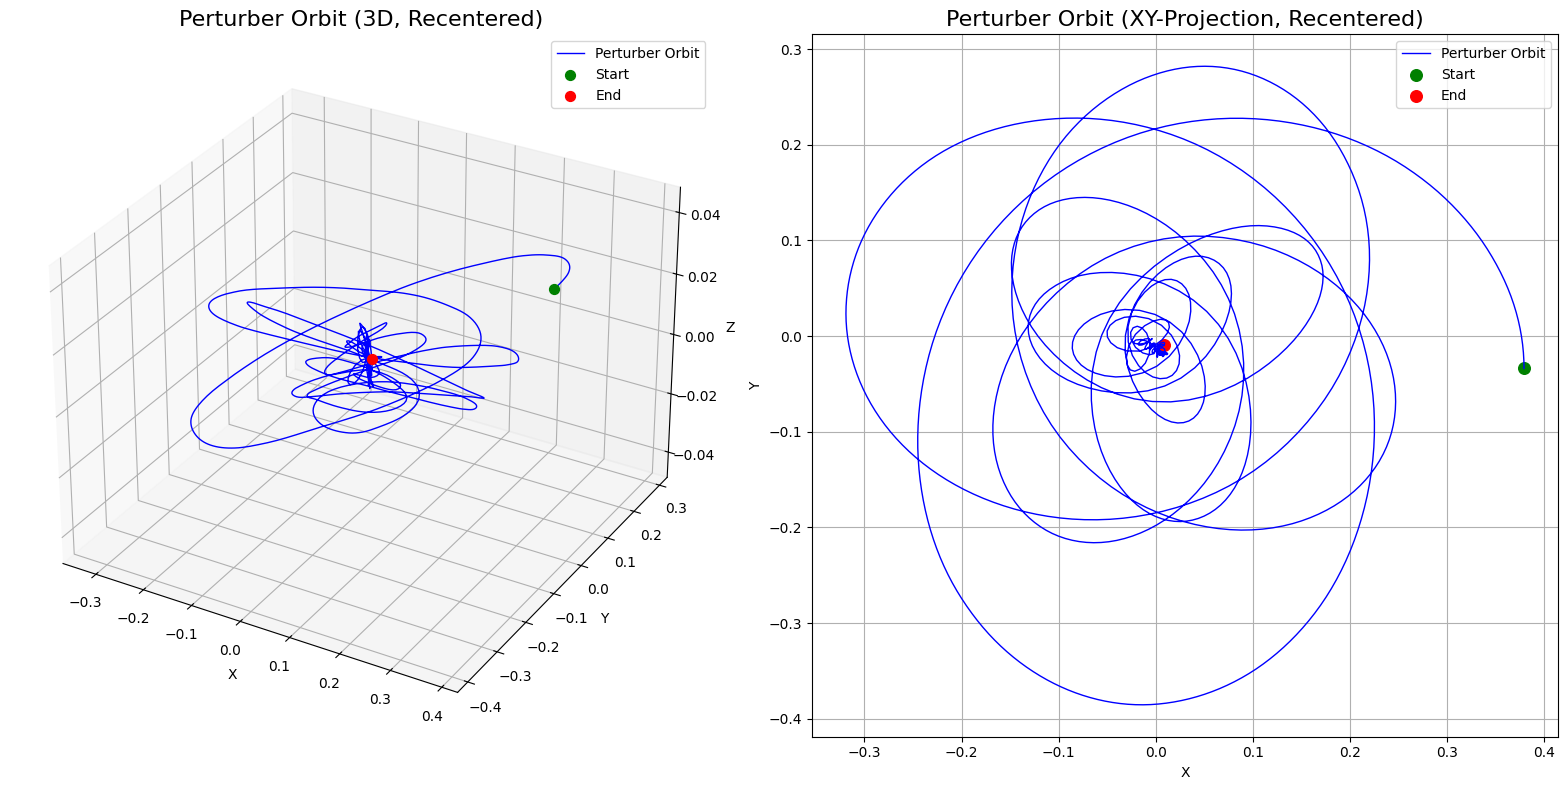

In [11]:
fig = plt.figure(figsize=(16, 8))

# 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_pert_rc, y_pert_rc, z_pert_rc, color='blue', lw=1, label='Perturber Orbit')
ax1.scatter(x_pert_rc[0], y_pert_rc[0], z_pert_rc[0], color='green', label='Start', s=50)
ax1.scatter(x_pert_rc[-1], y_pert_rc[-1], z_pert_rc[-1], color='red', label='End', s=50)
ax1.set_title("Perturber Orbit (3D, Recentered)", fontsize=16)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.legend()

# 2D Plot
ax2 = fig.add_subplot(122)
ax2.plot(x_pert_rc, y_pert_rc, color='blue', lw=1, label='Perturber Orbit')
ax2.scatter(x_pert_rc[0], y_pert_rc[0], color='green', label='Start', s=70)
ax2.scatter(x_pert_rc[-1], y_pert_rc[-1], color='red', label='End', s=70)
ax2.set_title("Perturber Orbit (XY-Projection, Recentered)", fontsize=16)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

#### Vertical (z-axis) Oscillations of the Perturber

The small-amplitude oscillations visible along the z-axis of the perturber’s orbit arise from a combination of physical and numerical effects. Initially, the perturber does not follow a perfectly planar trajectory—any slight inclination results in vertical motion due to the three-dimensional gravitational potential.

As the perturber sinks toward the center, the gravitational potential becomes more symmetric and shallower in the vertical direction. This causes the vertical restoring force to weaken, making the system more susceptible to vertical oscillations. Moreover, in the dense central region, the finite number of particles (especially with different masses) leads to local fluctuations in the force field, which can stochastically perturb the orbit in the z-direction.

Such vertical "jitter" is common in dynamical friction simulations and is not inherently unphysical. Instead, it reflects the combined influence of orbital geometry, resolution limits, and the live nature of the background distribution.


### Evolution of perturber's orbital radius, velocity and angular momentum  

The figure presents the time evolution of three fundamental orbital quantities for a massive object moving within the host galaxy: the radius $r(t)$, the velocity $v(t)$ and angular momentum $L(t)$. These plots trace how the orbit of the object evolves over time under the influence of the surrounding gravitational potential.

**Top panel - Radial motion**

The first panel shows the galactocentric radius of the object as a function of time. The oscillations reflect orbital motion, with each peak corresponding to an apocenter passage. Superimposed on this regular pattern is a clear secular decay in radius, indicating that the orbit is gradually shrinking. The spacing between peaks becomes tighter as the object moves inward, suggesting a change in orbital period and energy.

**Middle panel - Velocity Evolution**

The second panel displays the instantaneous speed of the object. The velocity exhibits a periodic pattern due to the transition between pericenter (faster) and apocenter (slower) phases. Over time, both the amplitude and frequency of these oscillations evolve. Initially, the object maintains a relatively stable orbital energy, but at later times the peaks shift, and a transition to noisier, lower velocities appears, possibly signaling a deeper interaction with the inner structure of the system.

**Bottom panel - Angular Momentum Evolution**

The specific angular momentum, represented in the third panel, is computed as the norm of the 3D cross product between position and velocity:
$$
\vec{L}(t) = \vec{r}(t) \times \vec{v}(t), \quad L(t) = \left\| \vec{L}(t) \right\|
$$
Unlike the periodicity of the radius and velocity, angular momentum displays a clear monotonic decline, indicating a sustained loss of tangential motion over time. The most significant changes tend to occur during pericenter passages, when the object moves quickly through dense central regions, enhancing the loss of angular momentum.

Overall, these three diagnostics reveal an object whose orbit evolves progressively—shrinking in size, changing in velocity structure, and steadily losing angular momentum. The physical cause behind this transformation will be explored in the next section.


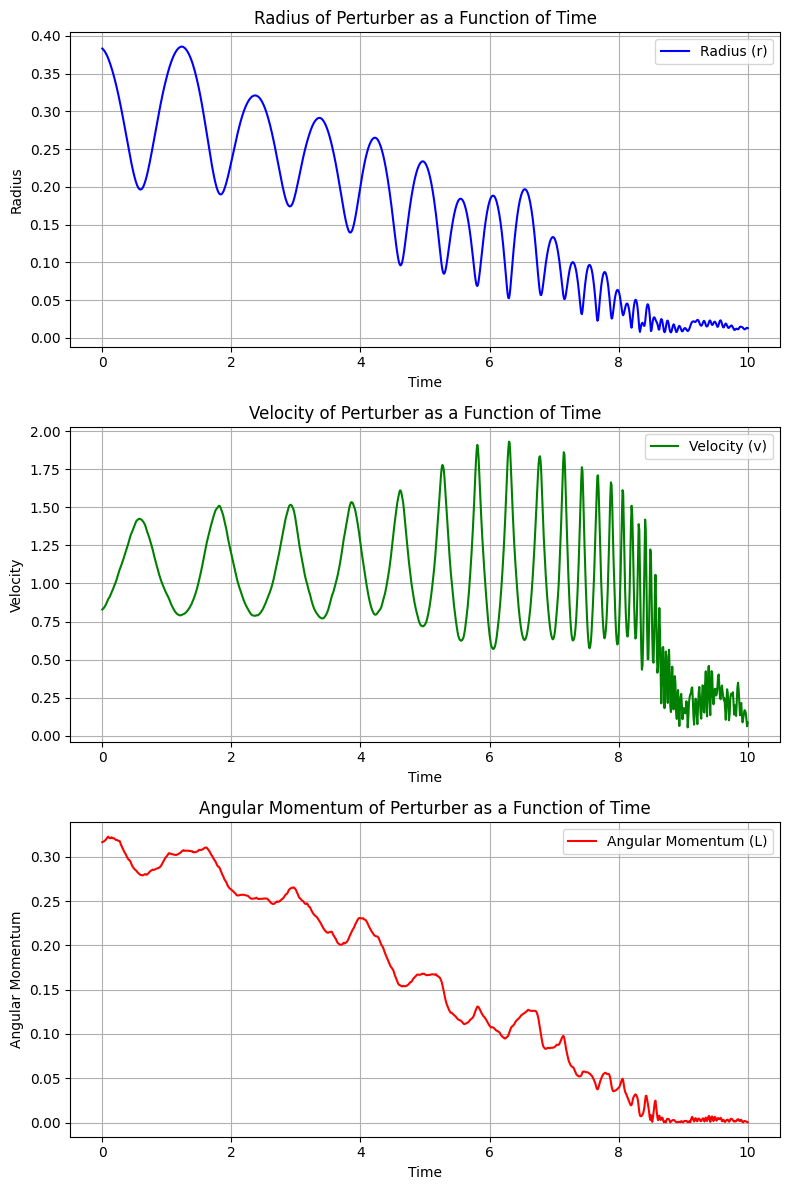

In [ ]:
# Compute angular momentum magnitude (L = r × v)
Lx = y_pert_rc * vz_pert_rc - z_pert_rc * vy_pert_rc
Ly = z_pert_rc * vx_pert_rc - x_pert_rc * vz_pert_rc   
Lz = x_pert_rc * vy_pert_rc - y_pert_rc * vx_pert_rc

L_pert = np.sqrt(Lx**2 + Ly**2 + Lz**2)

# Create plots
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

# 1. Radius vs. Time
ax[0].plot(time, r_pert_rc, label='Radius (r)', color='blue')
ax[0].set_title("Radius of Perturber as a Function of Time")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Radius")
ax[0].grid()
ax[0].legend()

# 2. Velocity vs. Time
ax[1].plot(time, v_pert_rc, label='Velocity (v)', color='green')
ax[1].set_title("Velocity of Perturber as a Function of Time")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Velocity")
ax[1].grid()
ax[1].legend()

# 3. Angular Momentum vs. Time
ax[2].plot(time, L_pert, label='Angular Momentum (L)', color='red')
ax[2].set_title("Angular Momentum of Perturber as a Function of Time")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Angular Momentum")
ax[2].grid()
ax[2].legend()

plt.tight_layout()
plt.show()

## Which is the physical process causing the perturber's behaviour?

The physical process driving the inspiral and eventual stalling of the perturber is **dynamical friction**, a gravitational drag force first described by Chandrasekhar (1943). 

When a massive object (the perturber) moves through a sea of background particles (e.g., stars or dark matter), it gravitationally attracts nearby particles, creating a gravitational wake behind it. This wake, in turn, exerts a net gravitational pull back on the perturber, effectively slowing it down.

### Chandrasekhar Dynamical Friction Formula

We start from the isotropic form of Chandrasekhar’s dynamical friction equation (Binney & Tremaine 2008, Eq. 8.3):

$$
\frac{d\mathbf{v}_M}{dt} = -16\pi^2 G^2 M m_a \ln \Lambda \left[ \int_0^{v_M} v_a^2 f(v_a) \, dv_a \right] \frac{\mathbf{v}_M}{v_M^3},
$$

where:
- $M$ is the mass of the perturber,
- $m_a$ is the mass of background particles,
- $f(v)$ is the **isotropic** velocity distribution function,
- $\ln \Lambda$ is the Coulomb logarithm,
- $v_M$ is the speed of the perturber.

---

We now recall that the number density $n$ of background particles is:

$$
n = \int f(\vec{v}) \, d^3v = 4\pi \int_0^\infty f(v)\, v^2 \, dv.
$$
Thus, in the **high-velocity limit**, where the perturber is much faster than all background particles (i.e., $v_M \gg v$) and **only stars moving slower than the perturber** contribute to the drag:

$$
\int_0^{v_M} f(v)\, v^2 \, dv \approx \int_0^\infty f(v)\, v^2 \, dv = \frac{n}{4\pi}.
$$

Then, we rewrite the prefactor in the original eq. :

$$
16\pi^2 G^2 M m_a \ln \Lambda = 4\pi G^2 M \ln \Lambda \cdot 4\pi m_a.
$$

Now we can reorganize the equation as:

$$
\frac{d\mathbf{v}_M}{dt} = -4\pi G^2 M \ln \Lambda \cdot  4\pi m_a \cdot \frac{n}{4\pi}  \cdot \frac{\mathbf{v}_M}{v_M^3}.
$$

The acceleration becomes (Binney & Tremaine 2008, eq. 8.5):

$$
\frac{d\mathbf{v}_M}{dt} = -4\pi G^2 M m_a n \ln \Lambda \cdot \frac{\mathbf{v}_M}{v_M^3}.
$$

We now rewrite this in terms of the **mass density** $\rho = n\, m_a$. Substituting (as also shown in Petts et al. (2016), eq. 1):

$$
\frac{d\mathbf{v}_M}{dt} = -4\pi G^2 M \rho \ln \Lambda \cdot \frac{\mathbf{v}_M}{v_M^3},
$$

recalling that:
- $M$: Mass of the perturber.
- $\mathbf{v}_M$: Velocity of the perturber relative to the background medium.
- $v_M = |\vec{v_M}|$: Magnitude of the velocity.
- $\rho$: Local density of the host, integrated over velocities less than $v_M$. Approximated as $\rho(r)$, the density at the perturber's position.
- $\ln\Lambda$: Coulomb logarithm, approximated as:
  $$
  \ln\Lambda = \ln\left(\frac{b_{\max}}{b_{\min}}\right),
  $$
  where $b_{\max} \sim r$ (orbital radius, approx. as the perturber starting radius) and $b_{\min}$ is the softening length or the minimum impact parameter.

Chandrasekhar's formula, although it is widely used and analytically beautiful, relies on **simplistic assumptions**: a massive object traversing an **infinite**, **homogeneous**, and **isotropic background**; approximating the DF by **considering only stars moving slower than the satellite**; and ignoring the velocity dependence of the strength of interactions (**isotropic velocity distribution**).\
However, **our system** — an elliptical galaxy modeled with a Hernquist profile embedded in a dark matter halo with an NFW profile — is **highly inhomogeneous**, **non-isotropic**, and **centrally concentrated** (cuspy profile). Moreover, during the orbital decay, the perturber moves through regions where the **majority of background particles may be faster**, violating a key premise of the classical theory. These departures raise doubts about the validity of applying the classical Chandrasekhar formula throughout the system, especially in the central regions where the perturber slows down. Thus, we are motivated to assess its limitations and explore more general or modified formulations.

## Test the limitations of classical dynamical friction formulation

When deriving the equation above, Chandrasekhar (1943) assumed that only stars moving slower than the satellite contribute to the frictional force. In most distributions this is a good approximation as there is an abundance of slow moving stars that all contribute to, and dominate, the friction. The effect of interactions with faster moving stars is fundamentally different, which can be demonstrated by considering the general Chandrasekhar formula (equations. 25 and 26 in Chandrasekhar(1943)) as did in Petts et al (2016).

Thus, we computed and visualized the **fraction of background particles moving slower than the perturber** as a function of time. 

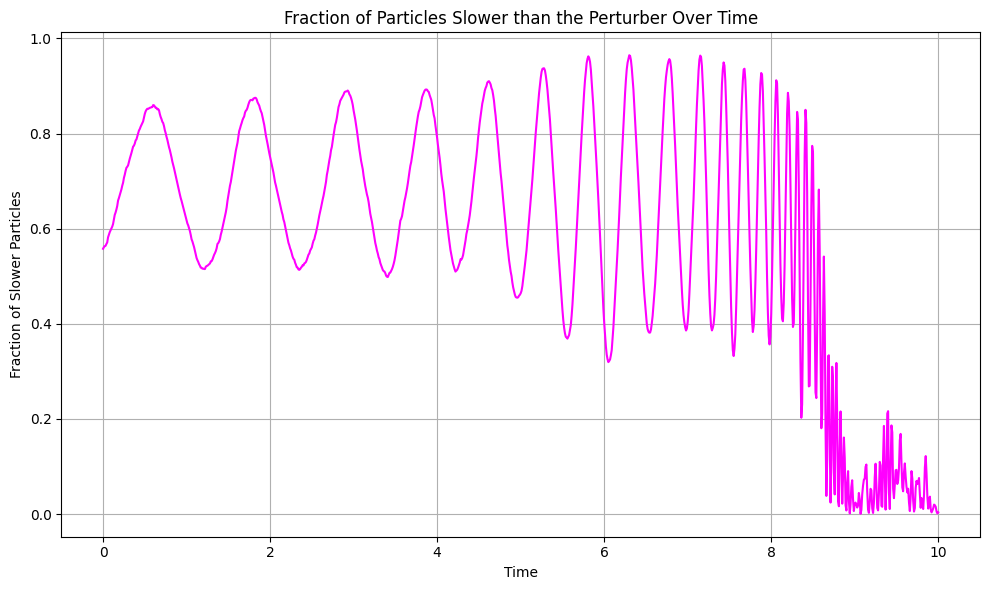

In [11]:
fraction_slower = np.mean(v_particle_rc < v_pert_rc, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(time, fraction_slower, color='magenta')
plt.xlabel('Time')
plt.ylabel('Fraction of Slower Particles')
plt.title('Fraction of Particles Slower than the Perturber Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observations

- The **fraction oscillates** periodically at first, due to the **eccentric orbit** of the perturber (speeding up near pericenter and slowing near apocenter).
- It **drops significantly** in the final phases of orbital decay, especially once the perturber reaches the **core** of the distribution.

This behavior tells us that:
- At **large radii**, the perturber moves faster than most background particles ⇒ high DF efficiency.
- At **small radii**, the perturber slows down, but the background density increases and **many particles move faster**, leading to a **decrease in DF efficiency**. We need to investigate whether it is significantly impacting on the DF mechanism.


#### Is it still possible to apply the Chandrasekhar Formula?

Yes — but with important adaptations.

To understand the applicability of classical dynamical friction (DF) in our **non-uniform system** (a Hernquist galaxy embedded in a NFW halo), the Chandrasekhar formula is applied **locally** by estimating the density around the perturber at each timestep.

##### Local Density Estimation

1. At each timestep, we computed the **radial distance** of all particles from the center of mass (excluding the perturber).
2. We divided the full radial range into **30 spherical bins**, uniformly spaced in radius.
3. For each bin, we computed the **total mass** using `scipy.stats.binned_statistic`.
4. The **local mass density** in each bin was estimated using:

   $$
   \rho_i = \frac{M_i}{\frac{4}{3} \pi (r_{i+1}^3 - r_i^3)}
   $$

5. We interpolated $\rho$ at the **perturber's instantaneous radius** to obtain the local density experienced by the perturber.
6. This interpolated $\rho$ was used in the **Chandrasekhar dynamical friction formula** to estimate the deceleration, assuming a fixed Coulomb logarithm in the first approach.

Below, the deceleration is computed via different DF models: 1. standard Chandrasekhar formula with only the local density correction; 2. some assumptionson the Coulomb logarithm are relaxed as proposed in Petts et al (2016); 3. the stalling phase of the perturber is evaluated.


---

### **Comparison of Dynamical Friction Prescriptions**

#### **Plot 1: Classical Chandrasekhar DF with Constant $\ln \Lambda$**

This model uses the traditional Chandrasekhar DF formula:

$$
\left| \vec{a}_{\text{DF}} \right| =  \Biggl|-\frac{4 \pi G^2 M \rho(<v_M) \ln\Lambda}{v_M^3} \vec{v_M}\Biggr|
$$

with a **constant** Coulomb logarithm given by: $\ln \Lambda = \ln\left(\frac{r_{\text{init}}}{\epsilon}\right)$, where: $r_{\text{init}}$ is the starting radius of the perturber and $\epsilon$ is the softening length.

The density $\rho(r)$ is computed via radial binning around the perturber's instantaneous position, assuming spherical symmetry, as described before.

**Observations**:
- The general trend (increasing acceleration toward the center) aligns with expectations.
- However, at **small radii**, the acceleration diverges unphysically. This is due to:
  - The assumption of $b_{\max} \gg b_{\min}$ breaking down,
  - The overestimation of $\ln \Lambda$ near the center,
  - And the **local number of slow-moving stars becoming very low** (low DF efficiency) which breaks the Chandrasekhar assumption,
  - Resulting in an artificially high acceleration.


In [ ]:
from scipy.stats import binned_statistic

# Constants
n_timesteps = r_particle_rc.shape[1]
rho_interp = np.zeros(n_timesteps)

# Set up bins once (global min/max of all particle radii)
rmin = np.min(r_particle_rc)
rmax = np.max(r_particle_rc)
bins = np.linspace(rmin, rmax, 30)
volumes = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Loop over time
for i in range(n_timesteps):
    r_t = r_particle_rc[:, i]  # radii of all particles at time i
    mass_binned = binned_statistic(r_t, masses_no_pert.flatten(), bins=bins, statistic='sum').statistic
    rho_binned = mass_binned / volumes
    rho_interp[i] = np.interp(r_pert_rc[i], bin_centers, rho_binned)



In [13]:
rho_interp.shape # it has the shape of the time vector and it represents the local density at the perturber's radius at each time step, so that we can assume homogeneity locally and apply the Chandrasekhar formula

(1001,)

In [14]:
G = 1
r_i = 0.3636 #starting radius of the perturber
M_enc = 0.252 # Encircled mass at the initial radius
epsilon = 0.01

v_c = np.sqrt(G * M_enc / r_i)
ln_Lambda = np.log(r_i / epsilon)

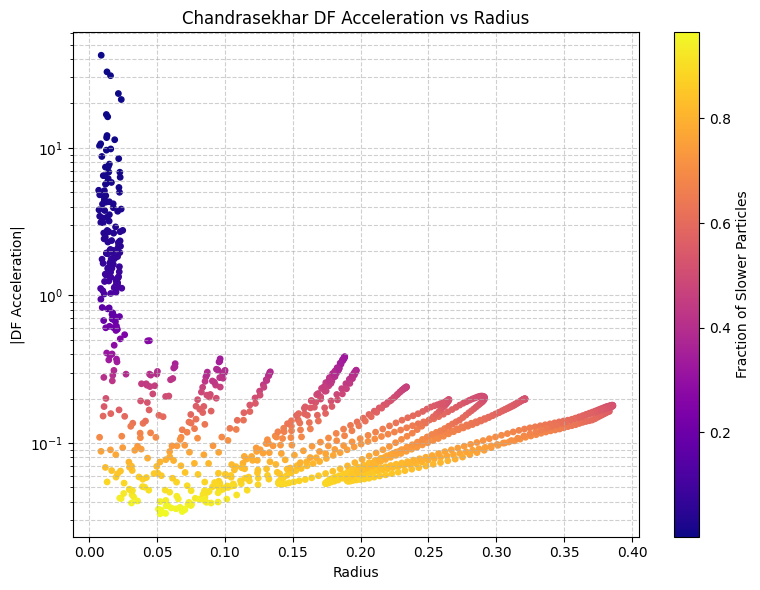

In [15]:
# Chandrasekhar DF acceleration
a_df_chandra = 4 * np.pi * G**2 * M_pert * rho_interp * ln_Lambda / (v_pert_rc**2)

# acceleration vs radius
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(r_pert_rc, a_df_chandra, c=fraction_slower, cmap='plasma', s=15)
cbar = plt.colorbar(sc, label="Fraction of Slower Particles") # color-coded by the fraction of slower-than-perturber particles at each point
ax.axhline(0, color='gray', linestyle='--')
ax.set_title("Chandrasekhar DF Acceleration vs Radius")
ax.set_xlabel("Radius")
ax.set_ylabel("|DF Acceleration|")
ax.set_yscale("log")
#ax.set_ylim(-5,0)
ax.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

### Results 

This revealed:

- At **intermediate radii**, where the fraction of slower stars is high, the DF estimate behaves smoothly and agrees well with expected trends.
- At **small radii**, where the fraction of slower particles drops below ~0.5:
  - The DF acceleration estimate becomes **unrealistically large**.
  - This is likely due to the breakdown of an assumption, indeed the perturber is now slower than most particles there.
  - The classical Chandrasekhar model **overestimates** the drag force here.


#### Why the Chandrasekhar Model Fails in the Core

In the central regions of the halo + galaxy system:

- The **density is high**, but the **velocity dispersion is also high**.
- The perturber becomes **slower than many background stars**.
- According to Chandrasekhar's theory, these fast particles **do not contribute** to DF — but in reality, they can.
- As noted by **Antonini & Merritt (2012)** and **Arca-Sedda & Capuzzo-Dolcetta (2014)**, fast particles can cause **dynamical buoyancy** or significantly modify the net force.

N.B. *Dynamical Buoyancy* = This effect is driven by the gravitational interactions with the surrounding stars. As the perturber approaches the center, it can transfer enough energy to the central stars to eject them, a process known as "scouring." This creates a central density core, or a region of lower stellar density, around the very center of the larger distribution.
Once this core is established, the nature of the gravitational forces on the perturber changes. The surrounding, denser regions of the stellar distribution can exert a net gravitational pull on the perturber that is directed away from the geometric center. This outward push, arising from the collective gravity of the stellar distribution, is what can be termed "dynamic buoyancy."


#### Conclusion

- **Classical Chandrasekhar DF** works reasonably well in **regions where the perturber is faster than most particles**, and the distribution is approximately Maxwellian.
- At **small radii**, especially in the **core**, the former one breaks down. A more accurate model should:
  - Relax some assumptions on the impact parameters and thus on the Coulomb logarithm as proposed in Petts et al 2016 (see the next section);
  - Include the contribution of **fast-moving particles** (e.g., via Petts et al. 2016 <u>complete</u> model, which is not included in this study);
  - Increase the resolution in the center, diminishing the theta angle and increase the dtime of the simulation to see better the behaviour in the center. Although, this implies a significant increment in the computational time of the simulation (which is why it's not performed here).

---

#### **Plot 2: Modified Chandrasekhar formula as in Petts et al. (2016) model**

The Petts formalism, while still primarily based on the slow-particle contribution, was designed for steep central cusps and varying environments.
In this model, we relax the assumption that $b_{\max} \gg b_{\min}$, which corrects the behavior when $b_{\max} \sim b_{\min}$. Thus the new expression of the acceleration is:

$$
\left| \vec{a}_{\text{DF}} \right| = \frac{2\pi G^2 M \rho (\ln^2 \Lambda + 1)}{v^2}
$$

and also, we rewrite the Coulomb logarithm expression so that it varies as a function of satellite position and velocity:

$$
\ln \Lambda = \ln\left( \frac{ \min\left(\rho(r)/|\nabla \rho(r)|,\, r \right)}{ \max\left(r_{\text{hm}},\, GM/v^2 \right)} \right)
$$

where $r$ is the satellite's galactocentric distance, $\rho(r)$ and $\nabla\rho(r)$ are the local density and first derivative of density at $r$, respectively. The maximum impact parameter is the region over which the density is approximately constant, so that the use of the local density, $\rho(r)$, is justified. If this exceeds the galactocentric distance, the galactocentric distance is used instead (see Just et al. 2011, for more information). The minimum impact parameter is given by the maximum of satellite size and the impact parameter for a 90 degree deflection from a typical interaction (see Petts et al. (2015)).

In [ ]:
drho_dr = np.gradient(rho_interp, r_pert_rc)

# Compute bmax and bmin
bmax = np.minimum(rho_interp / (np.abs(drho_dr) + 1e-10), r_pert_rc)
bmin = G* M_pert / v_pert_rc**2 # only this one because our satellites is point-like, so r_hm = 0
Lambda = bmax / bmin
ln_Lambda_petts = np.log(Lambda**2+1)


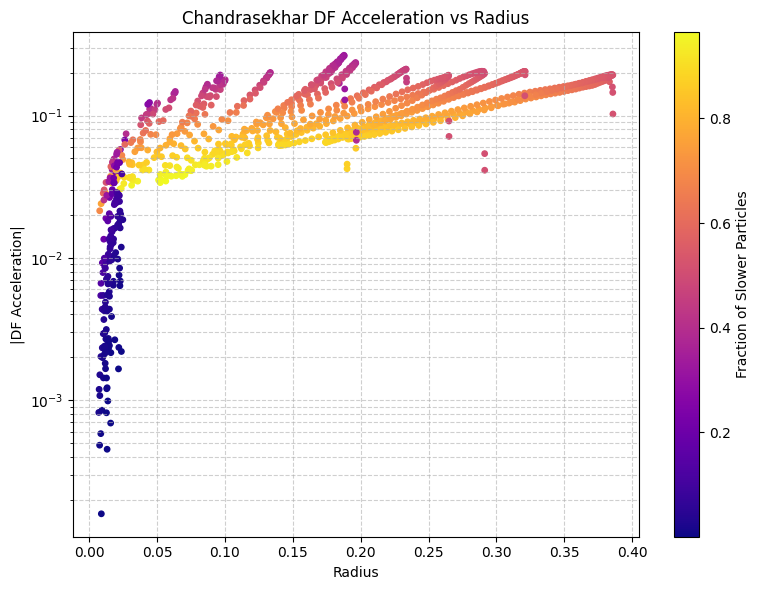

In [17]:
a_df_chandra1 = 2 * np.pi * G**2 * M_pert * rho_interp * ln_Lambda_petts / (v_pert_rc**2)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(r_pert_rc, a_df_chandra1, c=fraction_slower, cmap='plasma', s=15)
cbar = plt.colorbar(sc, label="Fraction of Slower Particles")
ax.axhline(0, color='gray', linestyle='--')
ax.set_title("Chandrasekhar DF Acceleration vs Radius")
ax.set_xlabel("Radius")
ax.set_ylabel("|DF Acceleration|")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Key improvements:
- The Coulomb logarithm varies locally with both position and velocity.
- Avoids divergence at small $r$ by adapting $b_{\max}$ to the local density gradient scale.
- Includes a better physical interpretation of the minimum impact parameter.

#### Observations:
- The divergence seen in Plot 1 is eliminated.
- The acceleration curve behaves more smoothly and realistically, especially in the central region.
- Still, some residual scatter and inconsistency remain at very small radii — mainly due to the inclusion of data **after the DF has stalled**.

### Interpretation of Low-Acceleration Region

When applying the Chandrasekhar dynamical friction formula *a posteriori*, I initially observed unrealistically high accelerations at small radii (e.g., $10^0–10^1$), even where the fraction of slower-than-perturber particles was near zero. This was due to applying the classical formula in a regime where its assumptions break down — specifically, where there are few or no slow background particles to contribute to dynamical friction, thus where DF is not efficient anymore.

After refining the model to use the true local velocity distribution and a modified Coulomb logarithm (as in Petts et al. 2016), the predicted acceleration correctly drops in the central region. This is evident in the current plot: the blue points at small radii represent zones where fast-moving background particles dominate and $f(<v_{\text{pert}})$ is low, leading to a suppression of dynamical friction. Their position *below* the main acceleration trend confirms that the frictional force weakens in these conditions, consistent with the physical mechanism behind orbital stalling.


---

#### **Plot 3: Petts Model + Truncated at Stalling Time**

To address the above limitation, we exclude data **after the stalling time** (e.g., $t > 8.81$), which is calculated as the time at which the orbital decay becomes negligible, so when $dr/dt \sim 0$. In this situation, indeed, the perturber is no longer efficiently losing orbital energy due to DF. In this study, to determine the stalling time, the $dr/dt \sim 0$ for 20 consecutive time steps within a certain tollerance threshold (0.05). See the code and the figures below.  Thus, after $t \sim 8.81$ the fraction of stars moving faster than the perturber becomes significant in the galactic core, the contribution of fast particles, indeed, can no longer be ignored.


Stall time detected at: 8.81 (if any)


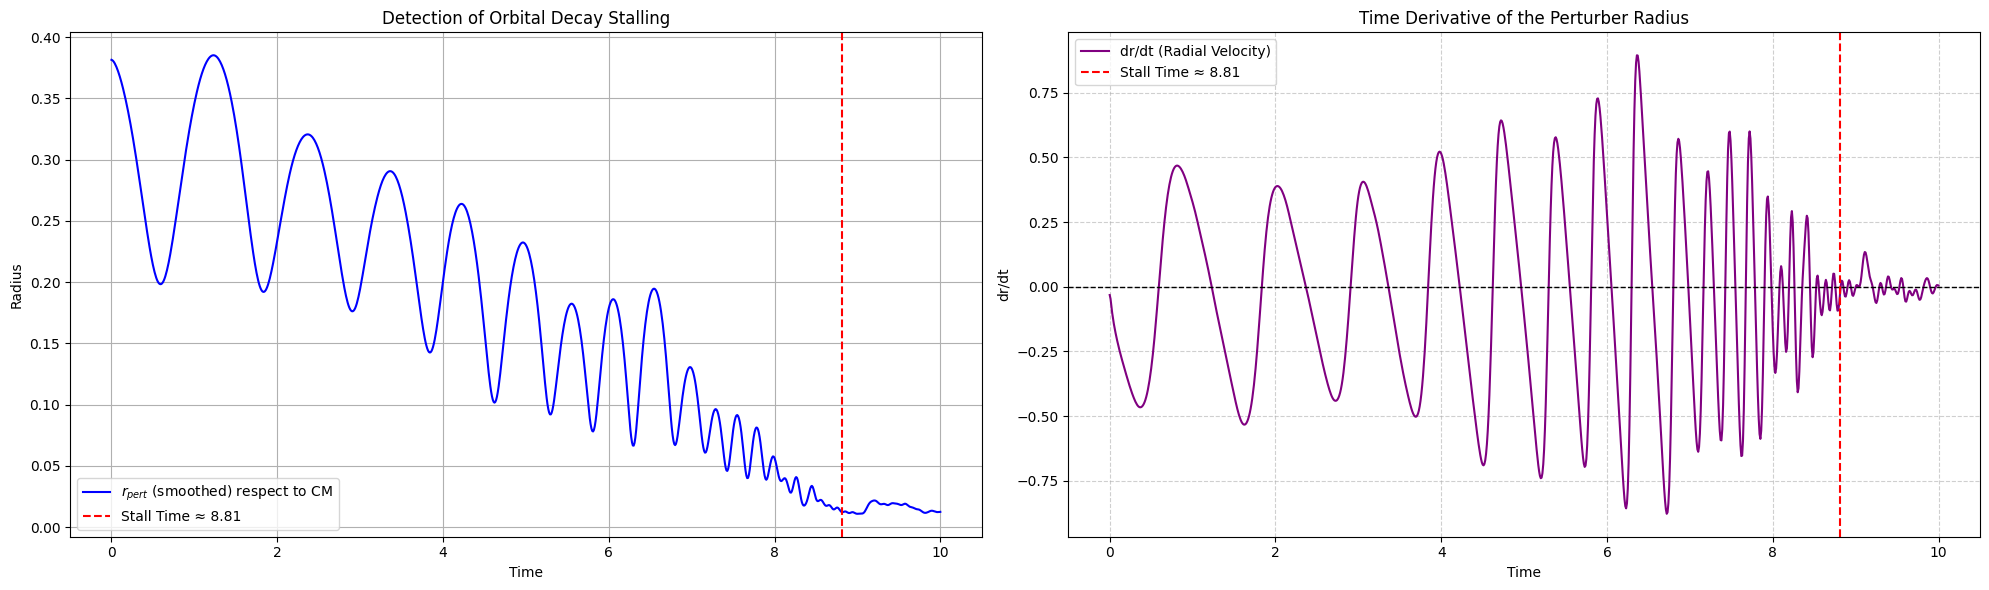

In [18]:
from scipy.ndimage import gaussian_filter1d
r_smoothed = gaussian_filter1d(r_pert_rc, sigma=3)

# Compute derivative
dr_dt = np.gradient(r_smoothed, time)

# Threshold for "stalling"
epsilon = 0.05

# Number of consecutive steps to check
window = 20

# Find the first index where the derivative stays below epsilon for 'window' steps
stall_index = None
for i in range(len(dr_dt) - window):
    if np.all(np.abs(dr_dt[i:i + window]) < epsilon):
        stall_index = i
        break

# Extract corresponding time if found
stall_time = time[stall_index] if stall_index is not None else None

print(f"Stall time detected at: {stall_time:.2f} (if any)")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First plot (radius)
ax1.plot(time, r_smoothed, label='$r_{pert}$ (smoothed) respect to CM', color='blue')
if stall_time is not None:
    ax1.axvline(stall_time, color='red', linestyle='--', label=f'Stall Time ≈ {stall_time:.2f}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Radius')
ax1.set_title('Detection of Orbital Decay Stalling')
ax1.legend()
ax1.grid(True)

# Second plot (derivative)
ax2.plot(time, dr_dt, label='dr/dt (Radial Velocity)', color='purple')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
if stall_time is not None:
    ax2.axvline(stall_time, color='red', linestyle='--', label=f'Stall Time ≈ {stall_time:.2f}')
ax2.set_title('Time Derivative of the Perturber Radius')
ax2.set_xlabel('Time')
ax2.set_ylabel('dr/dt')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()


At this point, excluding the data after the settlment in the core, we are not applying Chandrasekhar's formula blindly in regimes where its assumptions break down. Here below there is the plot that is obtained cutting out the data corresponding to the stalling phase.

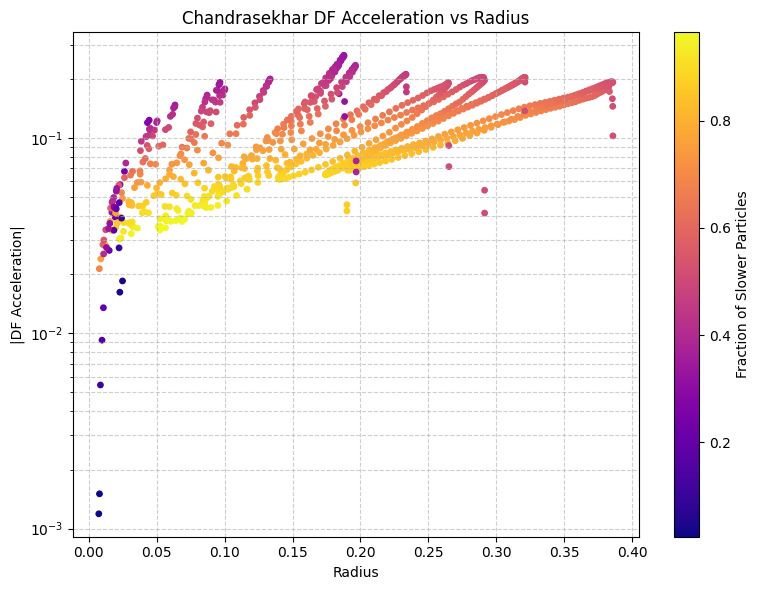

In [19]:
mask = time <= 8.81
r_pert_rc_cut = r_pert_rc[mask]
v_pert_rc_cut = v_pert_rc[mask]
fraction_slower_cut = fraction_slower[mask]
ln_Lambda_petts_cut = ln_Lambda_petts[mask]
rho_interp_cut = rho_interp[mask]

a_df_chandra1 = 2 * np.pi * G**2 * M_pert * rho_interp_cut * ln_Lambda_petts_cut / (v_pert_rc_cut**2)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(r_pert_rc_cut, a_df_chandra1, c=fraction_slower_cut, cmap='plasma', s=15)
cbar = plt.colorbar(sc, label="Fraction of Slower Particles")
ax.axhline(0, color='gray', linestyle='--')
ax.set_title("Chandrasekhar DF Acceleration vs Radius")
ax.set_xlabel("Radius")
ax.set_ylabel("|DF Acceleration|")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Observations:
- The acceleration vs. radius curve becomes much more coherent.
- Most regions with a low fraction of slow particles (typically in the core or at apocenter) are removed.
- It offers a faithful mapping of where DF is physically active.


---

### **Conclusion**

The comparison shows that:
- The **classical Chandrasekhar approximation** overestimates the DF in the core and does not adapt to local conditions.
- The **Petts et al. (2016) model** corrects the Coulomb logarithm, improving behavior especially at small radii.
- **Restricting the analysis to the DF-active phase**, i.e., before the perturber stalls, ensures the most physically accurate representation.

This justifies both the refinement of the theoretical model and the use of simulation-informed cutoffs to limit DF evaluation to where it is "truly" applicable.

---

## ATTENTION: THE ISOTROPIC VELOCITY IS STILL AN ASSUMPTION!! 

### Isotropy Diagnostics for the Background Distribution

To justify the application of Chandrasekhar's dynamical friction formula in our simulation, we need to verify that the velocity distribution of the background particles is approximately **isotropic**. This is a key assumption in both the classical and generalized forms of the drag equation.

We carried out two complementary analyses to assess this:

#### 1. Maxwellianity Check

We first evaluated whether the magnitude of the velocity vector $v = |\mathbf{v}|$ follows a Maxwellian distribution in different radial shells. For a system that is spherically symmetric and isotropic, the 3D velocity distribution function should resemble:

$$
f(v) \propto v^2 \exp\left(-\frac{v^2}{2\sigma^2}\right)
$$

This was tested by:
- Dividing the particle data into 4 radial shells: $[0.0, 0.25 \sim a_{hernquist}], [0.3, 3.0], [3.0, 8.0], [8.0, 18]$ IU.
- Fitting a Maxwellian distribution to the speed histogram chosen for a certain time of the simulation in each shell using `scipy.optimize.curve_fit`.
- Comparing the fitted profile to the true $f(v)$ histogram.

This test helps us check whether the velocity magnitudes are consistent with an isotropic equilibrium distribution. However, a Maxwellian shape alone does not guarantee **directional isotropy** - where the velocity distribution looks statistically the same in all directions: the three spherical velocity components should have similar shapes, spreads, and no preferred orientation - especially in the presence of streaming motions or anisotropic dispersions.

#### 2. Velocity Component Histograms in Radial Zones

To probe the directional symmetry of the velocity field, we examined the distributions of the three spherical velocity components: $v_r$ (radial), $v_\theta$ (polar), $v_\phi$ (azimuthal).

These were computed for each particle using:

$$
v_r = \frac{x v_x + y v_y + z v_z}{\sqrt{x^2 + y^2 + z^2}}, \quad
v_\phi = \frac{-y v_x + x v_y}{x^2 + y^2}
$$

For the polar component $v_\theta$, we used the projection:

$$
v_\theta = v_x \cos\theta \cos\phi + v_y \cos\theta \sin\phi - v_z \sin\theta
$$

where $\theta = \arccos\left(\frac{z}{r}\right)$ and $\phi = \arctan2(y, x)$ are the usual spherical angles.

We plotted the histograms of these components in the same radial zone of the Maxwellian analysis for the same chosen time.

In an **isotropic system**, these distributions should:
- Be centered around zero,
- Have similar widths and shapes.

This analysis helps us identify potential **radial or tangential biases** in different regions of the system, even when the overall $f(v)$ appears smooth.

Together, these diagnostics allow us to localize where isotropy holds—and where the assumptions underlying Chandrasekhar+Petts formulation may begin to break down.


In [21]:
print(f"Minimum radius: {r_particle_rc.min():.3f} IU")
print(f"Maximum radius: {r_particle_rc.max():.3f} IU")

Minimum radius: 0.000 IU
Maximum radius: 18.691 IU


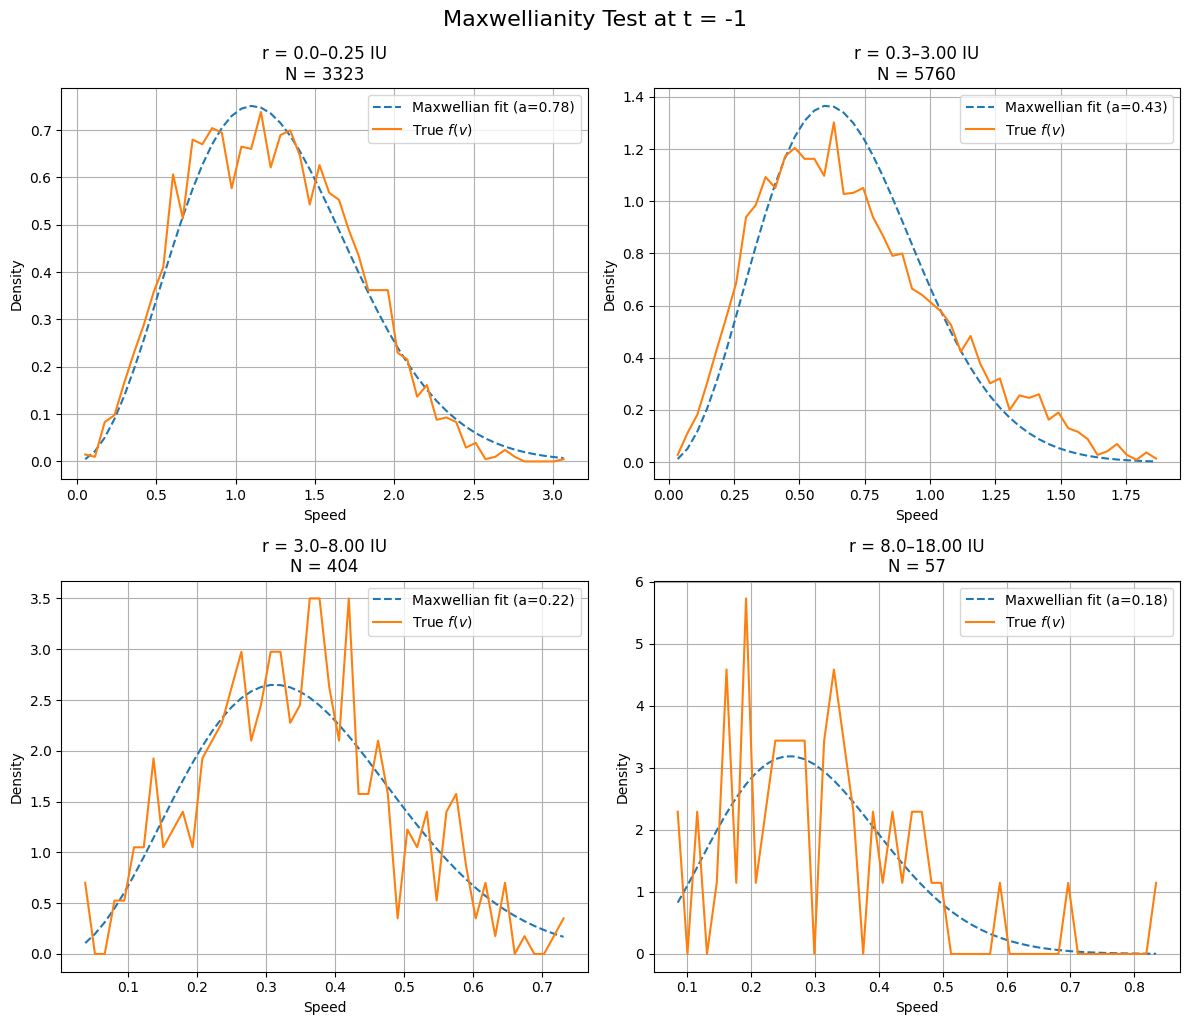

In [35]:
from scipy.stats import maxwell
from scipy.optimize import curve_fit

# Choose snapshot time index
t = -1  # Change this to explore different times

# Select values at that time
r_now = r_particle_rc[:, t]
v_now = v_particle_rc[:, t]

# Define 4 radial bins
r_bins = [(0.0, 0.25), (0.3, 3.0), (3.0, 8.0), (8.0, 18.0)]

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (rmin, rmax) in enumerate(r_bins):
    ax = axes.flat[i]
    
    mask = (r_now >= rmin) & (r_now < rmax)
    v_shell = v_now[mask]
    
    if len(v_shell) < 10:
        ax.set_title(f"{rmin:.1f}–{rmax:.1f} IU\n(too few particles)")
        ax.axis("off")
        continue

    counts, bin_edges = np.histogram(v_shell, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Fit Maxwellian
    try:
        def maxwell_fit(v, a):
            return maxwell.pdf(v, scale=a)

        popt, _ = curve_fit(maxwell_fit, bin_centers, counts, p0=[np.std(v_shell)])
        fitted = maxwell_fit(bin_centers, *popt)
        ax.plot(bin_centers, fitted, '--', label=f'Maxwellian fit (a={popt[0]:.2f})')
    except RuntimeError:
        ax.plot([], [], label='Fit failed')

    ax.plot(bin_centers, counts, label='True $f(v)$')
    ax.set_title(f"r = {rmin:.1f}–{rmax:.2f} IU\nN = {len(v_shell)}")
    ax.set_xlabel("Speed")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle(f"Maxwellianity Test at t = {t}", y=1.02, fontsize=16)
plt.show()



In [26]:
def plot_velocity_histograms_in_radial_ranges(
    rx, ry, rz, vx, vy, vz,
    radial_ranges, bin_counts=None, t=None
):
    r = np.sqrt(rx**2 + ry**2 + rz**2)
    theta = np.arccos(rz / (r + 1e-12))
    phi = np.arctan2(ry, rx)

    vr = (rx * vx + ry * vy + rz * vz) / (r + 1e-12)
    vtheta = ((vz * (rx * np.cos(phi) + ry * np.sin(phi)) -
              (vx * np.cos(theta) * np.cos(phi) + vy * np.cos(theta) * np.sin(phi))) / (r + 1e-12))
    vphi = (-ry * vx + rx * vy) / (rx**2 + ry**2 + 1e-12)

    n_panels = len(radial_ranges)
    n_rows = 2
    n_cols = (n_panels + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flat

    if bin_counts is None:
        bin_counts = [50] * n_panels

    for ax, (rmin, rmax), nbins in zip(axes, radial_ranges, bin_counts):
        mask = (r >= rmin) & (r < rmax)
        N = np.sum(mask)

        if N < 10:
            ax.set_title(f"{rmin} ≤ r < {rmax} IU\n(too few particles)")
            ax.axis('off')
            continue

        v_combined = np.concatenate([vr[mask], vtheta[mask], vphi[mask]])
        vmin, vmax = np.percentile(v_combined, [0.5, 99.5])

        ax.hist(vr[mask], bins=nbins, range=(vmin, vmax), alpha=0.5, label=r'$v_r$', density=True)
        ax.hist(vtheta[mask], bins=nbins, range=(vmin, vmax), alpha=0.5, label=r'$v_\theta$', density=True)
        ax.hist(vphi[mask], bins=nbins, range=(vmin, vmax), alpha=0.5, label=r'$v_\phi$', density=True)

        ax.set_title(f"{rmin} ≤ r < {rmax} IU\nN = {N}")
        ax.set_xlabel("Velocity")
        ax.grid(True)

    axes[0].set_xlim(-20, 20)
    axes[0].set_ylabel("Normalized count")
    axes[-1].legend(loc='upper right')

    if t is not None:
        fig.suptitle(f"Velocity component distributions at t = {t}", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


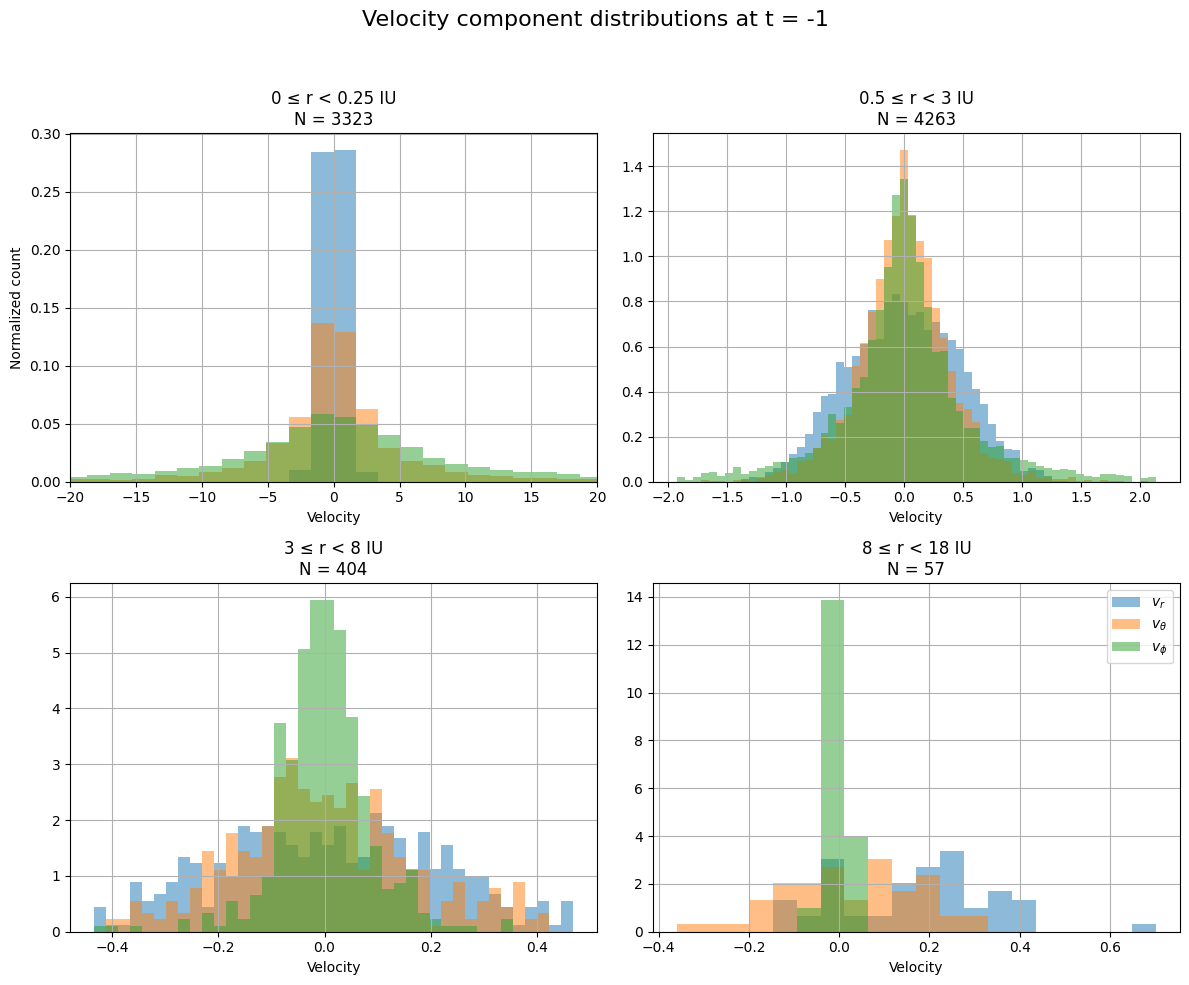

In [27]:
t = -1
rx_now = rx_rel[:, t]
ry_now = ry_rel[:, t]
rz_now = rz_rel[:, t]
vx_now = vx_rel[:, t]
vy_now = vy_rel[:, t]
vz_now = vz_rel[:, t]

# 4 radial bins for better resolution across the profile
radial_ranges = [(0, 0.25), (0.5, 3), (3, 8), (8, 18)]
bin_counts = [80, 60, 40, 20]  # adaptive resolution

plot_velocity_histograms_in_radial_ranges(
    rx_now, ry_now, rz_now, vx_now, vy_now, vz_now,
    radial_ranges=radial_ranges,
    bin_counts=bin_counts,
    t=t
)

These plots show a combined analysis of the velocity structure at a determined time, using two complementary diagnostics:

#### 1. Maxwellianity of $f(v)$

The first set of panels compares the histogram of the speed $v = |\vec{v}|$ with a fitted Maxwellian distribution in four radial shells. We observe that:

- In the **central regions** ($r \lesssim 3$ IU), the velocity distribution is approximately Maxwellian.
- At **intermediate radii** ($3 < r < 8$ IU), the fit begins to deviate, likely due to the dynamical evolution of the system or a departure from local equilibrium.
- In the **outermost region** ($r > 8$ IU), the particle count is low ($N = 41$), and the distribution is noisy — making the fit unreliable.

This confirms that while the Maxwellian assumption holds reasonably well in the dense inner regions, it becomes less accurate toward the outskirts.

#### 2. Directional symmetry of the velocity components

The second set of panels shows histograms of the radial ($v_r$), polar ($v_\theta$), and azimuthal ($v_\phi$) velocity components in the same radial shells.

We interpret directional symmetry (i.e., isotropy) as requiring:
- All three components to be centered around zero,
- Similar dispersion (histogram width),
- No systematic broadening or narrowing in one direction.

From the plots:
- The inner and intermediate zones show similar shapes and spreads in all components, consistent with isotropy.
- In the outermost bin, the distribution is noisy, and the $v_\phi$ component appears more peaked — though the sample size is too small to draw firm conclusions.

Together, these diagnostics suggest that the assumptions behind Chandrasekhar’s dynamical friction formula (especially isotropy and local Maxwellianity) are reasonably valid in the **inner** and **intermediate** regions at a fixed time, but must be treated with caution in the low-density outer halo. 

Please be aware that the considerations above are valid on different times (changing the $t$ parameter), but they are not reported for semplicity.


The aim of this section is to compare the deceleration caused by the dynamical friction effect, as modelled in the previous sections, with the acceleration that results from the simulation. What we expect is that the simulated acceleration includes the contributions of multiple effects. One of the easiest to recognize is the effect of the gravitational potential, so, in the following procedure, it is taken into account. Below a description of the logical and physical steps is reported.

#### 1. Simulated Acceleration

The total acceleration of the perturber is obtained by numerically differentiating its velocity components with respect to time:

$$
\vec{a}_{\text{sim}} = \frac{d\vec{v}}{dt}
$$

This gives the instantaneous acceleration at each point along the orbit. The **magnitude** of the simulated acceleration is:

$$
|\vec{a}_{\text{sim}}| = \sqrt{a_x^2 + a_y^2 + a_z^2}
$$

We also compute the **component of acceleration parallel to the velocity vector**:

$$
a_{\parallel} = \frac{\vec{a}_{\text{sim}} \cdot \vec{v}}{|\vec{v}|}
$$

This measures whether the perturber is speeding up or slowing down along its path — a direct indicator of dissipative effects.

#### 2. Gravitational Acceleration from the Analytic Potential

We compute the expected gravitational acceleration from the combined Hernquist + NFW mass distribution, assuming spherical symmetry:

$$
a_{\text{grav}}(r) = -\frac{G M_{\text{enc}}(r)}{r^2}
$$

with

$$
M_{\text{enc}}(r) = M_{\text{Hern}}(r) + M_{\text{NFW}}(r)
$$

The radial gravitational acceleration is then projected onto Cartesian coordinates:

$$
\vec{a}_{\text{grav}} = a_{\text{grav}}(r) \cdot \frac{\vec{r}}{|\vec{r}|}
$$

This is the acceleration the perturber would experience if it were a test particle moving in a static, collisionless potential.

#### 3. Residual (Drag) Acceleration

To extract the **drag force**, we subtract the analytic gravitational acceleration from the total simulated acceleration:

$$
\vec{a}_{\text{drag}} = \vec{a}_{\text{sim}} - \vec{a}_{\text{grav}}
$$

The component of this drag vector **parallel to the motion** is:

$$
a_{\parallel, \text{drag}} = \frac{\vec{a}_{\text{drag}} \cdot \vec{v}}{|\vec{v}|}
$$

This quantity isolates the **effective deceleration** due to residual forces (e.g., dynamical friction), as it only includes the part of the acceleration acting *against* the motion of the perturber.

#### 4. Interpretation of the Plots

- **Left panel**: Compares the parallel component of the simulated drag acceleration to the analytic prediction from the Chandrasekhar + Petts model. This validates whether the simulated drag matches theory.
- **Right panel**: Shows how $a_{\parallel, \text{drag}}$ evolves over time — giving insight into how the drag force strengthens as the perturber moves toward denser regions of the galaxy.

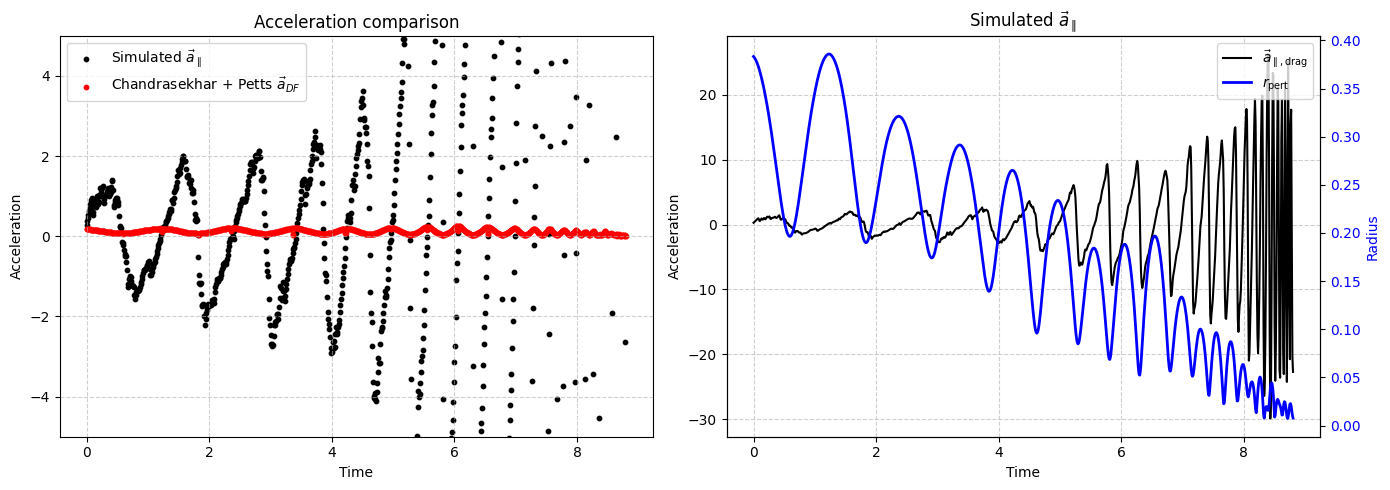

In [ ]:
dt= time[1] - time[0]  # Time step
mask = time <= 8.81
# Compute simulated acceleration components
ax_sim = np.gradient(vx_pert_rc[mask], dt)
ay_sim = np.gradient(vy_pert_rc[mask], dt)
az_sim = np.gradient(vz_pert_rc[mask], dt)
a_sim_mag = np.sqrt(ax_sim**2 + ay_sim**2 + az_sim**2)
a_parallel = (ax_sim * vx_pert_rc[mask] + ay_sim * vy_pert_rc[mask] + az_sim * vz_pert_rc[mask]) / (v_pert_rc_cut + 1e-12)


def enclosed_mass_total(r):
    M_hern = M_hernquist * (r**2) / (r + a_hernquist)**2
    M_nfw = M_NFW * (np.log(1 + r/r_s) - (r/r_s)/(1 + r/r_s)) / (np.log(1 + c) - c/(1 + c))
    return M_hern + M_nfw

def a_grav_radial(r):
    M_enc = enclosed_mass_total(r)
    return -G * M_enc / (r**2 + 1e-12)

a_grav_r = a_grav_radial(r_pert_rc_cut)
a_grav_x = a_grav_r * x_pert_rc[mask] / r_pert_rc_cut
a_grav_y = a_grav_r * y_pert_rc[mask] / r_pert_rc_cut
a_grav_z = a_grav_r * z_pert_rc[mask] / r_pert_rc_cut


ax_drag = ax_sim - a_grav_x
ay_drag = ay_sim - a_grav_y
az_drag = az_sim - a_grav_z

a_parallel_drag = (ax_drag * vx_pert_rc[mask] + ay_drag *  vy_pert_rc[mask] + az_drag * vz_pert_rc[mask]) / (v_pert_rc_cut + 1e-12)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Acceleration comparison
ax[0].scatter(time[mask], a_parallel_drag, s=10, label='Simulated $\\vec{a}_{\parallel}$', color='black')

ax[0].scatter(time[mask], a_df_chandra1, s=10, label='Chandrasekhar + Petts $\\vec{a}_{DF}$', color='red')

ax[0].set_ylim(-5, 5)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Acceleration")
ax[0].set_title("Acceleration comparison")
ax[0].legend()
ax[0].grid(True, which="both", linestyle="--", alpha=0.6)


# Panel 2: simulated parallel acceleration
ax[1].plot(time[mask], a_parallel_drag, color='black', label='$\\vec{a}_{\parallel, \\mathrm{drag}}$')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Acceleration")
ax[1].set_title("Simulated $\\vec{a}_{\\parallel}$")
ax[1].grid(True, linestyle="--", alpha=0.6)

# Add secondary y-axis for r(t)
ax_r = ax[1].twinx()
ax_r.plot(time[mask], r_pert_rc_cut, color='blue', lw=2, label='$r_{\\mathrm{pert}}$')
ax_r.set_ylabel("Radius", color='blue')
ax_r.tick_params(axis='y', labelcolor='blue')

# Add legends
lines1, labels1 = ax[1].get_legend_handles_labels()
lines2, labels2 = ax_r.get_legend_handles_labels()
ax[1].legend(lines1 + lines2, labels1 + labels2, loc="upper right")


plt.tight_layout()
plt.show()

### Important observations on the left panel:
In the comparison between the simulated acceleration and the analytical prediction from the Chandrasekhar + Petts dynamical friction (DF) model, we observe that the modeled DF acceleration (red curve) reaches its peak values during the ascending phase of the simulated parallel acceleration (black points), typically just after each pericentric passage. This behavior can be understood by considering the physics behind dynamical friction. In the Chandrasekhar framework, DF arises primarily from background particles that move slower than the perturber. These slower particles are gravitationally focused behind the perturber, creating a wake that pulls back on it and causes a drag force. The faster the perturber moves, the larger the fraction of background particles that are slower than it, and thus the stronger the resulting drag. Near pericenter, the perturber reaches its highest speed as it plunges into the dense central region of the galaxy. This combination of high velocity and high background density makes the DF force strongest at or just after pericenter. In the simulation, this strong drag causes a rapid deceleration (negative acceleration) that reaches a minimum slightly before the peak in the modeled DF. As the perturber begins to move outward again and its speed decreases, the simulated acceleration transitions upward—this is when the modeled DF curve peaks. The slight offset between the two reflects the orbital dynamics: while the DF model assumes steady-state conditions and instantaneous velocity dependence, the simulation includes additional effects such as tidal forces, time-dependent density variations, and phase-dependent orbital motion.

### Right panel

#### Net Deceleration from Envelope Slopes

To investigate whether the simulated perturber experiences a net deceleration due to dynamical friction, it is analyzed the time evolution of its parallel acceleration component, $\vec{a}_{\parallel, \mathrm{drag}}$. Using `scipy.signal.find_peaks`, both the negative and positive peaks of the acceleration curve are identified and then it is performed a linear fit to their envelopes using `np.polyfit`. The slopes of these envelopes reveal the trend in the strength of deceleration and re-acceleration events over time.

Therefore, the calculation reveals that the **absolute value of the slope of the negative peak envelope** is **3.40**, while that of the positive peaks is **2.93** (in acceleration units per time unit). This asymmetry indicates that the **magnitude of deceleration events is consistently stronger than that of acceleration events**, implying that the perturber loses more momentum than it regains in each orbital cycle.

As a result, this cumulative imbalance leads to a **net deceleration**, consistent with the physical expectations of dynamical friction. This effect is also reflected in the decreasing orbital radius over time, as shown by the overlaid blue curve of $r_{\mathrm{pert}}$, confirming that the perturber is spiraling inward due to sustained energy and momentum loss.


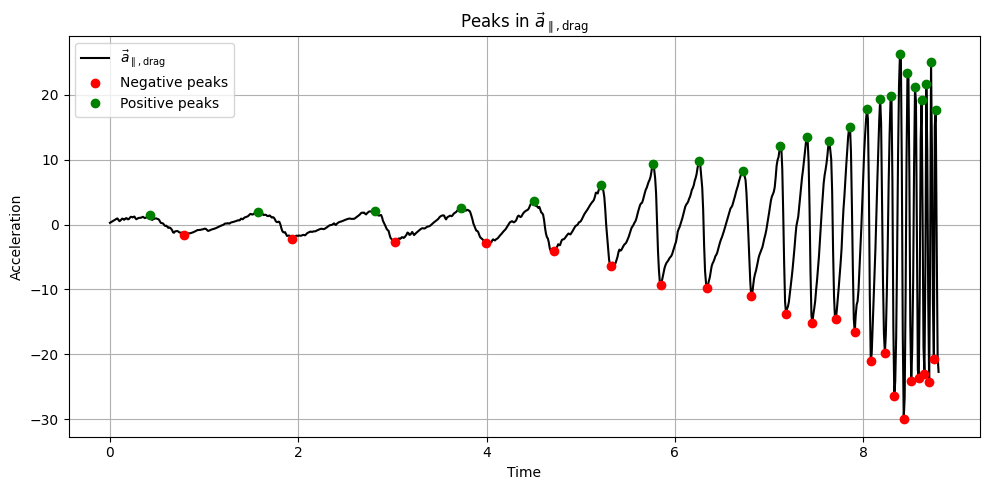

In [ ]:
from scipy.signal import find_peaks

# Find positive and negative peaks
positive_peaks, _ = find_peaks(a_parallel_drag, prominence=1)  
inverted_signal = -a_parallel_drag
peaks, _ = find_peaks(inverted_signal, prominence=1)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(time[mask], a_parallel_drag, color='black', label=r'$\vec{a}_{\parallel, \mathrm{drag}}$')
ax1.plot(time[mask][peaks], a_parallel_drag[peaks], 'ro', label='Negative peaks')
ax1.plot(time[mask][positive_peaks], a_parallel_drag[positive_peaks], 'go', label='Positive peaks')
ax1.set_xlabel("Time")
ax1.set_ylabel("Acceleration")
ax1.set_title("Peaks in $\\vec{a}_{\\parallel,\\mathrm{drag}}$")
ax1.grid(True)
ax1.legend() 

plt.tight_layout()
plt.show()

In [26]:
t_peaks = time[mask][peaks]
a_peaks = a_parallel_drag[peaks]

t_positive_peaks = time[mask][positive_peaks]
a_positive_peaks = a_parallel_drag[positive_peaks]

# Fit a straight line: a_peaks = slope * t_peaks + intercept
slope, intercept = np.polyfit(t_peaks, a_peaks, 1)
slope_positive, intercept_positive = np.polyfit(t_positive_peaks, a_positive_peaks, 1)

print(f"Absolute value of the slope of the negative peak envelope: {np.abs(slope):.2f} (acceleration units per time unit)")
print(f"Absolute value of the slope of the positive peak envelope: {np.abs(slope_positive):.2f} (acceleration units per time unit)")


Absolute value of the slope of the negative peak envelope: 3.40 (acceleration units per time unit)
Absolute value of the slope of the positive peak envelope: 2.93 (acceleration units per time unit)


---

## Conclusions

In this notebook, we studied the orbital decay of a massive perturber spiraling into an elliptical galaxy described by a Hernquist profile and embedded in a dark matter halo modeled with a Navarro-Frenk-White (NFW) profile. The evolution was analyzed through a high-resolution N-body simulation, and the resulting dynamics were compared against theoretical predictions from Chandrasekhar dynamical friction and its extensions.

- **Equilibrium Validation**:  
  Before inserting the perturber, we tested the stability of the combined galaxy-halo system using:
  - **Lagrangian radii**, which settled after a short transient phase (violent relaxation),
  - The **virial ratio**, which stabilized around ⟨2T/|U|⟩ ≈ 0.96 after *t ≈ 10.5*,  
  confirming that the system reached dynamical equilibrium.

- **Perturber's Evolution**:
  - The perturber was initially placed at $\sim 1.5 \times a_{hernquist}$ along the x axis.
  - It exhibited a gradual inward spiral, **losing angular momentum and energy** over time, also resulting in a radial decay.
  - The orbital decay eventually **stalled** as it reached the galaxy’s core, identified around *t ≈ 8.81* by analyzing $dr/dt$.

- **Dynamical Friction (DF) Modeling**:
  - The classical **Chandrasekhar DF formula** was applied using a local density estimate.
  - However, in the central regions where many background particles are faster than the perturber, the standard formula **overestimated** the deceleration.
  - To improve the modeling, we adopted the **Petts et al. (2016)** formulation, which:
    - Accounts for variations in the Coulomb logarithm,
    - Eliminates unphysical divergences at small radii,
    - Better matches the behavior seen in the simulation.

- **Model Validation**:
  - We showed that the **drag acceleration** extracted from the simulation partly matches the theoretical DF prediction (Petts model), especially during the active inspiral phase.
  - Envelope analysis of the parallel acceleration confirmed **net deceleration**, with stronger decelerating events compared to accelerating ones.
  
- **Limits of Applicability**:
  - The classical theory breaks down near the galactic core due to:
    - Anisotropy,
    - High density and high velocity dispersion,
    - The dominance of fast particles (violating the slow-particle approximation).
  - Isotropy diagnostics showed that while the velocity distribution is **approximately isotropic** in the inner and intermediate regions, caution must be taken in the outskirts or dense core.

- **Possible improvements**:

    - Higher Resolution Simulations:
        - Increase the total number of particles to reduce discreteness noise, especially in the dense inner regions.
        - Decrease the gravitational softening length and time step to better resolve the central potential and perturber-core interactions.

    - Improved Time Resolution:
        - Use adaptive time-stepping near pericenter passages to capture more accurately the sharp variations in acceleration and dynamical friction.

    - More Advanced DF Models:
        - Implement the full Petts et al. (2016) prescription, which includes the contribution from fast-moving background particles.
        - Explore semi-analytical approaches that incorporate phase-space distribution anisotropy and time-dependent density profiles.


## ANIMATION of the system galaxy + halo + perturber

See the last cell for the gif, portraying the perturber spiraling toward the center of mass of the distribution

In [ ]:
galaxy_indices = np.arange(0, 3000)
dm_indices = np.arange(3000, 10000)

Creating animation...


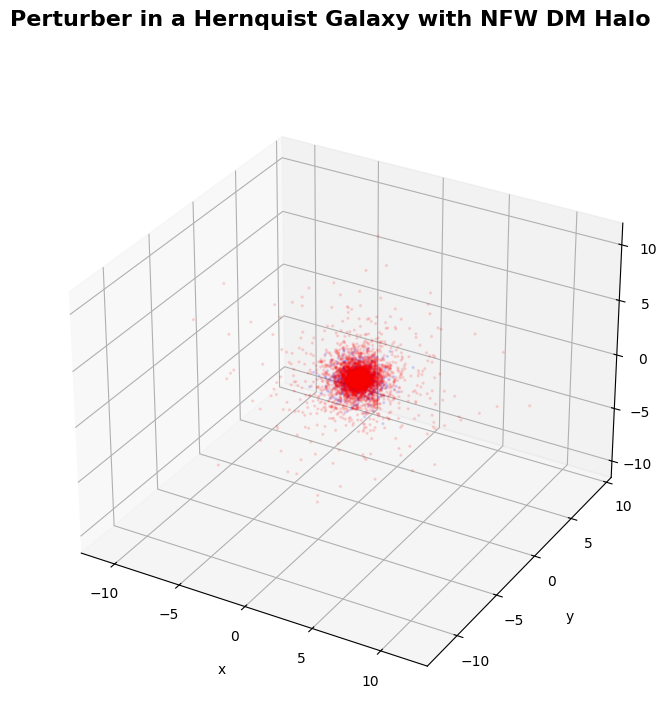

Progress: 0.1%
Progress: 0.1%
Progress: 1.1%
Progress: 2.1%
Progress: 3.1%
Progress: 4.1%
Progress: 5.1%
Progress: 6.1%
Progress: 7.1%
Progress: 8.1%
Progress: 9.1%
Progress: 10.1%
Progress: 11.1%
Progress: 12.1%
Progress: 13.1%
Progress: 14.1%
Progress: 15.1%
Progress: 16.1%
Progress: 17.1%
Progress: 18.1%
Progress: 19.1%
Progress: 20.1%
Progress: 21.1%
Progress: 22.1%
Progress: 23.1%
Progress: 24.1%
Progress: 25.1%
Progress: 26.1%
Progress: 27.1%
Progress: 28.1%
Progress: 29.1%
Progress: 30.1%
Progress: 31.1%
Progress: 32.1%
Progress: 33.1%
Progress: 34.1%
Progress: 35.1%
Progress: 36.1%
Progress: 37.1%
Progress: 38.1%
Progress: 39.1%
Progress: 40.1%
Progress: 41.1%
Progress: 42.1%
Progress: 43.1%
Progress: 44.1%
Progress: 45.1%
Progress: 46.1%
Progress: 47.1%
Progress: 48.1%
Progress: 49.1%
Progress: 50.0%
Progress: 51.0%
Progress: 52.0%
Progress: 53.0%
Progress: 54.0%
Progress: 55.0%
Progress: 56.0%
Progress: 57.0%
Progress: 58.0%
Progress: 59.0%
Progress: 60.0%
Progress: 61.0%
Pro

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)
ax.set_zlabel("z", labelpad=10)
fig.suptitle("Perturber in a Hernquist Galaxy with NFW DM Halo", fontsize=16, weight='bold')

# Initial plots using CM-relative coordinates
scat_gal = ax.scatter(x_no_pert[galaxy_indices, 0], y_no_pert[galaxy_indices, 0], z_no_pert[galaxy_indices, 0], 
                      c='blue', s=2, alpha=0.1, label="Galaxy Particles")
scat_dm = ax.scatter(x_no_pert[dm_indices, 0], y_no_pert[dm_indices, 0], z_no_pert[dm_indices, 0], 
                     c='red', s=2, alpha=0.1, label="DM Particles")
scat_perturber = ax.scatter([x_pert_rc[0]], [y_pert_rc[0]], [z_pert_rc[0]], 
                            c='black', s=50, alpha=1.0, label="Perturber")

# Axis limits for zooming (relative to CM, which is now at [0,0,0])
zoom_center = np.array([0, 0, 0])
zoom_start = 1.5
zoom_end = 0.2
frames_total = len(time)

# Animation update function
def update(frame):
    # Update positions using CM-relative coordinates
    scat_gal._offsets3d = (x_no_pert[galaxy_indices, frame], 
                           y_no_pert[galaxy_indices, frame], 
                           z_no_pert[galaxy_indices, frame])
    scat_dm._offsets3d = (x_no_pert[dm_indices, frame], 
                          y_no_pert[dm_indices, frame], 
                          z_no_pert[dm_indices, frame])
    scat_perturber._offsets3d = ([x_pert_rc[frame]], 
                                 [y_pert_rc[frame]], 
                                 [z_pert_rc[frame]])

    # Accelerated zoom
    #zoom_progress = (frame / frames_total) ** 5
    zoom_progress = 1 - np.exp(-6 * frame / frames_total)
    zoom_factor = zoom_start + (zoom_end - zoom_start) * zoom_progress

    ax.set_xlim(zoom_center[0] - zoom_factor, zoom_center[0] + zoom_factor)
    ax.set_ylim(zoom_center[1] - zoom_factor, zoom_center[1] + zoom_factor)
    ax.set_zlim(zoom_center[2] - zoom_factor, zoom_center[2] + zoom_factor)

    ax.set_title(f"Time: {time[frame]:.2f}")

    # Progress print
    progress = (frame + 1) / frames_total * 100
    if frame % max(1, frames_total // 100) == 0:
        print(f"Progress: {progress:.1f}%")

# Create animation
print("Creating animation...")
ani = FuncAnimation(fig, update, frames=frames_total, interval=45)

plt.grid(True, alpha=0.02)
plt.show()

# Save GIF safely using PillowWriter
writer = PillowWriter(fps=15)
ani.save("galaxy_dm_zoom_perturber_20_05_final1.gif", writer=writer, dpi=150)
print("Animation saved!")


### To see the animation follow the link:

[Click here to watch the animation](https://drive.google.com/file/d/1_ZE4DwFY8HF-6bX_oZzfEplBn7uTk8KC/view?usp=drive_link)
